Max polarity: 1.0
Min polarity: 0.0


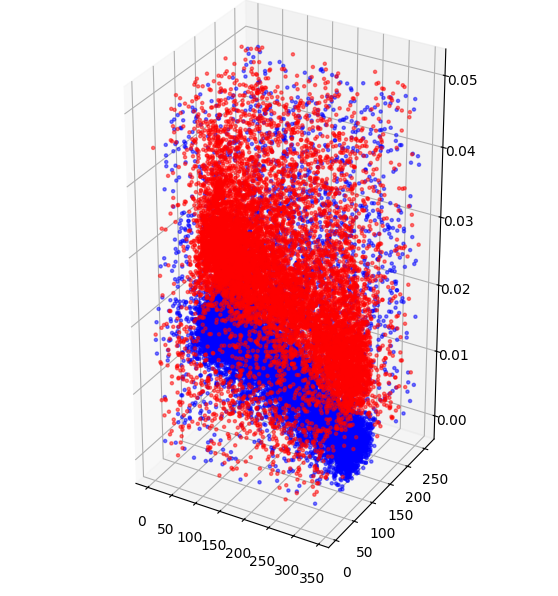

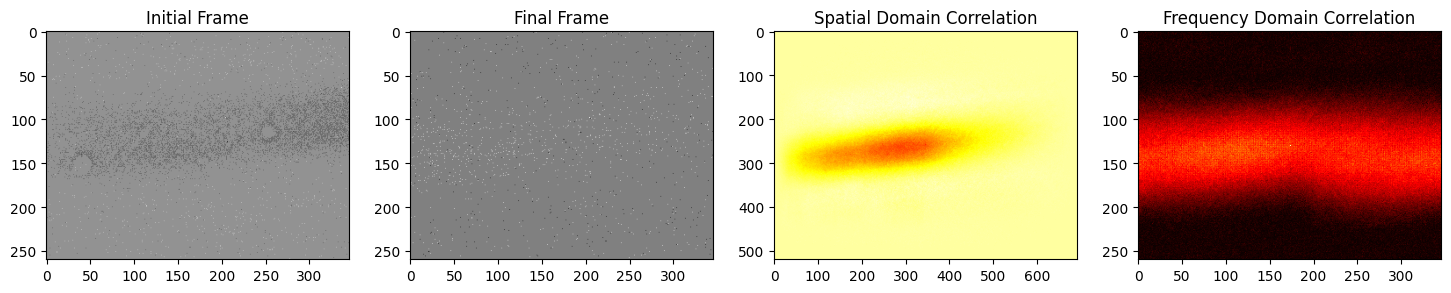

Spatial Peak Location: (tensor([148, 160], device='cuda:0'), tensor([345, 309], device='cuda:0'))
sensor_size:  (260, 346)
peak_spatial:  (tensor([148, 160], device='cuda:0'), tensor([345, 309], device='cuda:0'))


RuntimeError: a Tensor with 2 elements cannot be converted to Scalar

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

# Set default tensor type to float32
torch.set_default_dtype(torch.float32)


# Define sensor size and device
sensor_size = (260, 346)
aspect_ratio = sensor_size[0] / sensor_size[1]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Read data
# path = "/home/lachlan/Projects/rapid_organoid_imaging/csv/8-22-24/droplet-oil-136-water-40-2-percent-detergent_classfied/exposure_200k_velocity_0250ms/dvSave-2024_08_22_21_44_03/events_dvSave-2024_08_22_21_44_03_slice_250ms_acc_10ms/events_slice_172.npy"
path = "/home/lachlan/ProjectsLFS/rapid_organoid_imaging/selected_frames/speed_50ms/speed_50ms_segments/segment_000004.npy"
events = np.load(path)
# events[:, 0] *= 1e6  # Scale timestamps

# Print min and max polarities
print(f"Max polarity: {events[:, -1].max()}")
print(f"Min polarity: {events[:, -1].min()}")

# Extract and normalize time and event coordinates
ts, xs, ys, ps = events[:, 0], events[:, 1], events[:, 2], events[:, 3]
ts -= ts.min()
ps = (ps - 0.5) * 2

# Filter events within a specific window
time_window = 60e3
mask = ts < time_window
ts, xs, ys, ps = ts[mask], xs[mask], ys[mask], ps[mask]
ts -= ts.min()

# Determine if polarity mode is active
polar = True
if polar:
    # Separate positive and negative events
    pos_mask = ps > 0
    neg_mask = ps <= 0
    pos_xs, pos_ys, pos_ts = xs[pos_mask], ys[pos_mask], ts[pos_mask]
    neg_xs, neg_ys, neg_ts = xs[neg_mask], ys[neg_mask], ts[neg_mask]

    # Create 3D plot with different colors for polarities
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': '3d'})
    ax.set_box_aspect([1.0, 1.0, 2.0])
    ax.scatter(pos_xs, pos_ys, pos_ts / 1e6, c='red', alpha=0.5, marker=".")
    ax.scatter(neg_xs, neg_ys, neg_ts / 1e6, c='blue', alpha=0.5, marker=".")
else:
    # Standard plotting without polarity distinction
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': '3d'})
    ax.set_box_aspect([1.0, 1.0, 5.0])
    ax.scatter(xs, ys, ts / 1e6, c='black', alpha=0.1, marker=".")

plt.show()

# Utility functions
def np_to_torch(xs, ys, ts, ps, device):
    """
    Convert numpy arrays to PyTorch tensors.
    """
    return torch.tensor(xs, device=device), torch.tensor(ys, device=device), torch.tensor(ts, device=device), torch.tensor(ps, device=device)

def time_window(xs, ys, ts, ps, start, duration):
    """
    Extract events within a specified time window.
    """
    mask = (ts >= start) & (ts < start + duration)
    return xs[mask], ys[mask], ts[mask], ps[mask]

def generate_image_from_events(xs, ys, ps, sensor_size, device, start_time, end_time):
    """
    Generate an image from a subset of event data within a specified time window.
    
    Args:
    xs, ys, ps (torch.Tensor): Event coordinates and polarities.
    sensor_size (tuple): Size of the output image (height, width).
    device (torch.device): Device to perform computations on.
    start_time (float): Start time for the event window.
    end_time (float): End time for the event window.
    
    Returns:
    torch.Tensor: Image tensor created from events within the specified window.
    """
    # Filter events within the specified time window
    valid = (ts >= start_time) & (ts <= end_time)
    xs_win, ys_win, ps_win = xs[valid], ys[valid], ps[valid]
    
    # Initialize the image tensor
    image = torch.zeros(sensor_size, device=device, dtype=torch.float)  # Explicit dtype specification
    
    # Ensure all tensors are of the same data type (float)
    indices = (ys_win.long() * sensor_size[1] + xs_win.long()).long()
    ps_win = ps_win.float()  # Convert polarity data to float if not already
    
    # Map events to the image
    image.view(-1).index_add_(0, indices, ps_win)

    return image

def frequency_correlation(a, b):
    # Compute FFT of both images
    fa = torch.fft.fft2(a)
    fb = torch.fft.fft2(b)
    # Compute cross-correlation in frequency domain
    fc = fb * torch.conj(fa)
    # Convert back to spatial domain, normalize, and shift the zero-frequency component to the center
    correlation = torch.fft.ifft2(fc).abs()
    m, n = b.shape
    correlation = torch.fft.fftshift(correlation) / (m * n)
    return correlation

def spatial_correlation(a, b):
    # Calculate the necessary padding: half the dimensions of b on all sides
    pad_height = b.shape[0] // 2
    pad_width = b.shape[1] // 2
    # Pad b and then use it as the input to conv2d, a is flipped to act as the kernel
    b_padded = F.pad(b, (pad_width, pad_width, pad_height, pad_height), mode='constant', value=0)
    # Compute cross-correlation
    return F.conv2d(b_padded[None, None, :, :], a[None, None, :, :], padding='same')

def frequency_correlation(a, b):
    # Compute FFT of both images
    fa = torch.fft.fft2(a)
    fb = torch.fft.fft2(b)
    # Compute cross-correlation in frequency domain
    fc = fb * torch.conj(fa)
    # Convert back to spatial domain, normalize, and shift the zero-frequency component to the center
    correlation = torch.fft.ifft2(fc).abs()
    m, n = b.shape
    correlation = torch.fft.fftshift(correlation) / (m * n)
    return correlation


# # Load data
# path = "/home/lachlan/Projects/rapid_organoid_imaging/csv/8-22-24/droplet-oil-136-water-40-2-percent-detergent_classfied/exposure_200k_velocity_0250ms/dvSave-2024_08_22_21_44_03/events_dvSave-2024_08_22_21_44_03_slice_250ms_acc_10ms/events_slice_172.npy"
# events = np.load(path)
# sensor_size = (260, 346)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Process events
# ts, xs, ys, ps = events[:, 0], events[:, 1], events[:, 2], events[:, 3]
# ts = (ts - ts.min()) * 1e6
xs, ys, ts, ps = np_to_torch(xs, ys, ts, ps, device)

# Determine initial and final frames for autocorrelation
win = int(ts.max().item() / 4)

# Calculate windows
total_duration = ts.max().item()
win = int(total_duration / 4)
start_time_initial = 0
end_time_initial = win
start_time_final = total_duration - win
end_time_final = total_duration


# Generate initial and final frames for autocorrelation
initial_frame = generate_image_from_events(xs, ys, ps, sensor_size, device, start_time_initial, end_time_initial)
final_frame = generate_image_from_events(xs, ys, ps, sensor_size, device, start_time_final, end_time_final)



# Calculate both correlations
corr_spatial = spatial_correlation(initial_frame, final_frame)
corr_frequency = frequency_correlation(initial_frame, final_frame)

# Normalize for better visualization
corr_spatial = corr_spatial[0, 0] / corr_spatial.max()
corr_frequency = corr_frequency / corr_frequency.max()

# Plotting results
fig, axs = plt.subplots(1, 4, figsize=(18, 6))
axs[0].imshow(initial_frame.cpu(), cmap='gray')
axs[0].set_title('Initial Frame')
axs[1].imshow(final_frame.cpu(), cmap='gray')
axs[1].set_title('Final Frame')
axs[2].imshow(corr_spatial.cpu(), cmap='hot')
axs[2].set_title('Spatial Domain Correlation')
axs[3].imshow(corr_frequency.cpu(), cmap='hot')
axs[3].set_title('Frequency Domain Correlation')
plt.show()

# Find peaks to estimate velocity, as an example
peak_spatial = torch.nonzero(corr_spatial == torch.max(corr_spatial), as_tuple=True)
# peak_frequency = torch.nonzero(corr_frequency == torch.max(corr_frequency), as_tuple=True)

# Display peak information
print(f"Spatial Peak Location: {peak_spatial}")
# print(f"Frequency Peak Location: {peak_frequency}")

# Compute velocity
print("sensor_size: ", sensor_size)
print("peak_spatial: ", peak_spatial)
# peak_spatial = peak_spatial[1]
sensor_x, sensor_y = [sensor_size[1], sensor_size[0] ]  # Assuming [width, height] order
peak_x, peak_y = peak_spatial[1].item(), peak_spatial[0].item()

# Calculate velocity components in pixels per microsecond
velocity_x = (peak_x - sensor_x) / ts.max().item()
velocity_y = (peak_y - sensor_y) / ts.max().item()

print(f"Velocity X: {velocity_x} pixels per microsecond")
print(f"Velocity Y: {velocity_y} pixels per microsecond")
print(f"Shifted pixels: ", velocity_y * ts.max().item())

In [10]:
# print("model.velocity: ", model.velocity)

[[-767.50767538]
 [ 110.00110006]]
iter num --> 0 loss --> -0.08413408696651459
iter num --> 1 loss --> -0.08413459360599518
iter num --> 2 loss --> -0.08413515239953995
iter num --> 3 loss --> -0.08413566648960114
iter num --> 4 loss --> -0.0841362327337265
iter num --> 5 loss --> -0.08413685113191605
iter num --> 6 loss --> -0.08413732796907425
iter num --> 7 loss --> -0.08413773030042648
iter num --> 8 loss --> -0.0841381773352623
iter num --> 9 loss --> -0.08413862437009811
iter num --> 10 loss --> -0.08413907140493393
iter num --> 11 loss --> -0.08413957059383392
iter num --> 12 loss --> -0.08414008468389511
iter num --> 13 loss --> -0.0841405913233757
iter num --> 14 loss --> -0.08414110541343689
iter num --> 15 loss --> -0.08414160460233688
iter num --> 16 loss --> -0.08414209634065628
iter num --> 17 loss --> -0.08414255082607269
iter num --> 18 loss --> -0.08414305001497269
iter num --> 19 loss --> -0.08414352685213089
iter num --> 20 loss --> -0.08414402604103088
iter num -->

iter num --> 195 loss --> -0.08417660742998123
iter num --> 196 loss --> -0.0841766893863678
iter num --> 197 loss --> -0.08417679369449615
iter num --> 198 loss --> -0.08417687565088272
iter num --> 199 loss --> -0.08417699486017227
iter num --> 200 loss --> -0.08417709171772003
iter num --> 201 loss --> -0.08417723327875137
[[-767.63416996]
 [ 110.07760395]]


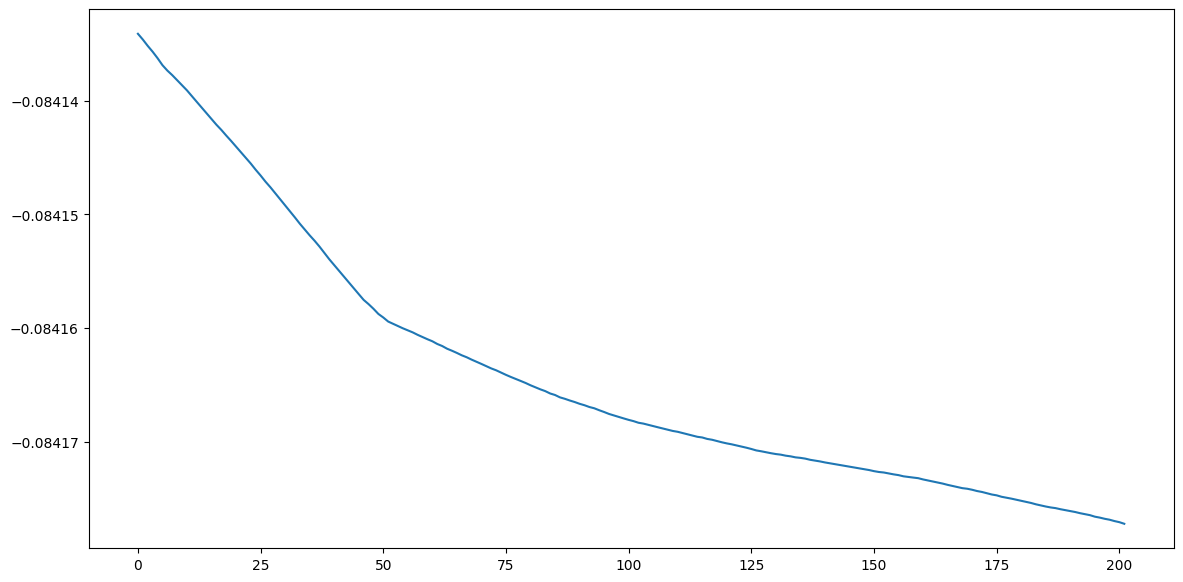

In [83]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


def bilinear_interpolation(xt, yt, pt, image_size, polar=True, device=None):
    """
    Perform bilinear interpolation and accumulate into an image tensor.
    :param xt: Tensor of x coordinates
    :param yt: Tensor of y coordinates
    :param pt: Tensor of weights or intensities associated with each coordinate
    :param image_size: Tuple of (height, width) specifying the size of the output image
    :param polar: Boolean indicating if polarities should affect the interpolation weights
    :param device: The device on which to perform computations
    :return: A 2D tensor representing the interpolated image
    """
    if device is None:
        device = xt.device
    
    # Ensure that coordinates and polarities are all floats
    xt = xt.float()
    yt = yt.float()
    pt = (pt.float() if polar else torch.ones_like(pt).float())

    # Initialize the image tensor on the specified device as Float
    img = torch.zeros(image_size, device=device, dtype=torch.float)

    # Ensure coordinates are within the image boundaries
    valid_x = (xt >= 0) & (xt < image_size[1])
    valid_y = (yt >= 0) & (yt < image_size[0])
    valid = valid_x & valid_y

    # Apply the valid mask
    xt, yt, pt = xt[valid], yt[valid], pt[valid]
    pxs = xt.floor().long()
    pys = yt.floor().long()
    dxs = xt - pxs
    dys = yt - pys

    # Accumulate contributions using bilinear interpolation
    for dx, dy in [(0, 0), (1, 0), (0, 1), (1, 1)]:
        temp_pxs = pxs + dx
        temp_pys = pys + dy
        weights = pt * ((1 - dxs) if dx == 0 else dxs) * ((1 - dys) if dy == 0 else dys)

        # Guard against out-of-bounds indices
        within_bounds = (temp_pxs < image_size[1]) & (temp_pys < image_size[0])
        img.index_put_((temp_pys[within_bounds], temp_pxs[within_bounds]), weights[within_bounds], accumulate=True)

    return img






class MotionCompensation(nn.Module):
    def __init__(self, initial_velocities):
        super().__init__()
        # Initialize the velocity parameters that will be optimized during training.
        self.velocities = nn.Parameter(initial_velocities)

    def warp(self, x_coords, y_coords, timestamps, polarities, reference_time):
        """
        Apply a velocity-based warp to the coordinates based on the time difference from a reference time.
        """
        time_diff = timestamps - reference_time
        velocity_x, velocity_y = self.velocities / delta_t
        # velocity_x, velocity_y = self.velocities
        warped_x_coords = x_coords - velocity_x * time_diff
        warped_y_coords = y_coords - velocity_y * time_diff
        return warped_x_coords, warped_y_coords

    def forward(self, x_coords, y_coords, timestamps, polarities, reference_time):
        """
        Process events through the model by warping them and then converting to an image.
        """
        warped_x, warped_y = self.warp(x_coords, y_coords, timestamps, polarities, reference_time)
        # Compute the image of warped events using bilinear interpolation.
        image_of_warped_events = bilinear_interpolation(warped_x, warped_y, polarities, sensor_size, device=None)
        # Calculate the variance of the image as the loss to be minimized.
        loss = -torch.var(image_of_warped_events)
        return image_of_warped_events, loss

def training_loop(model, xs, ys, ts, ps, ilr=5e-1, iter=40):
    loss_val = []
    for i in range(iter):
        image_of_warped_events, loss = model(xs, ys, ts, ps, 0)
        
        if i <= 50:
            optimizer = torch.optim.Adam(model.parameters(), lr=ilr)
        elif i >50 &  i < 100:
            optimizer=torch.optim.Adam(model.parameters(), lr=ilr*5e-1)
        elif i > 100 &  i <= 200:
             optimizer = torch.optim.Adam(model.parameters(), lr=ilr*1e-1)
        elif i > 200:
             optimizer = torch.optim.Adam(model.parameters(), lr=ilr*1e-2, weight_decay= 0.80)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print("iter num -->", i, "loss -->", loss.item())
        
        loss_val.append(loss.item())
        if i > 200:
            if np.abs(loss_val[-1] + loss_val[-2] - loss_val[-3] - loss_val[-4]) < 1e-6:
                break
                
    return image_of_warped_events, loss_val


delta_t = ts.max()

## initialization model
initial_velocities = np.asarray([[velocity_x], [velocity_y]]) * delta_t.cpu().numpy()
print(initial_velocities)
# Dxy_0= - np.asarray([[0.],[0.]])

initial_velocities = torch.from_numpy(initial_velocities).to(device)
model = MotionCompensation(initial_velocities)

### train loss
image_of_warped_events, losses = training_loop(model, xs, ys, ts, ps, iter = 2000,ilr=1e-3)
image_of_warped_events =image_of_warped_events.detach().cpu()

plt.figure(figsize=(14, 7))
plt.plot(losses)

final_velocities = model.velocities.detach().cpu().numpy()
# final_velocities = final_velocities / delta_t.cpu().numpy()
print(final_velocities)



In [84]:
final_velocities

array([[-767.63416996],
       [ 110.07760395]])

In [85]:
# final_velocities[[0]] = -346
# final_velocities[[1]] = 50

In [86]:
# final_velocity, velocity_y

In [87]:
delta_t

tensor(49998., device='cuda:0', dtype=torch.float64)

In [88]:
final_velocities

array([[-767.63416996],
       [ 110.07760395]])

In [89]:
ts

tensor([0.0000e+00, 2.0000e+00, 1.3000e+01,  ..., 4.9945e+04, 4.9971e+04,
        4.9998e+04], device='cuda:0', dtype=torch.float64)

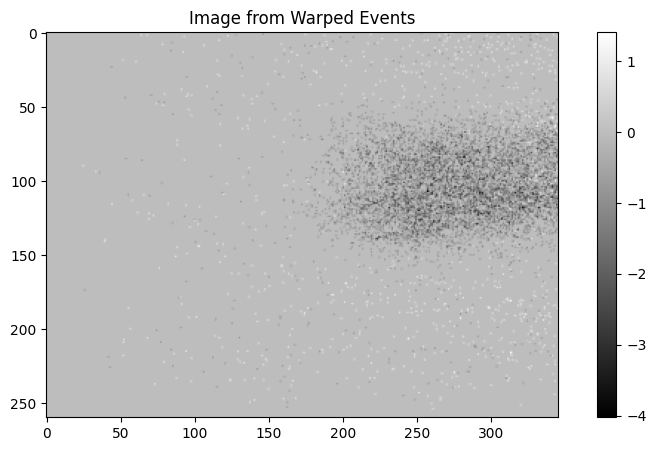

In [90]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def warp(xs, ys, ts, t0, v_xx, v_yy):
    """
    Warp the x and y coordinates based on the velocity and time difference.
    """
    dt = ts - t0
    warp_x = xs - v_xx * dt
    warp_y = ys - v_yy * dt
    return warp_x, warp_y



# Warp the events
xw, yw = warp(xs, ys, ts, ts.min(), torch.tensor(final_velocities[0], device="cuda")/delta_t.item(), torch.tensor(final_velocities[1], device="cuda")/delta_t.item())

# Generate image from warped events
image_from_warped_events = bilinear_interpolation(xw, yw, ps, sensor_size, polar=True)

# Plotting the output
plt.figure(figsize=(10, 5))
plt.imshow(image_from_warped_events.cpu(), cmap='gray')
plt.colorbar()
plt.title("Image from Warped Events")
plt.show()


xs.min():  tensor(24.6746, device='cuda:0', dtype=torch.float64)
xs.max():  tensor(1102.7446, device='cuda:0', dtype=torch.float64)
ys.min():  tensor(-107.3031, device='cuda:0', dtype=torch.float64)
ys.max():  tensor(253.9207, device='cuda:0', dtype=torch.float64)
valid_mask:  tensor([ True,  True,  True,  ..., False, False, False], device='cuda:0')
valid_mask.shape:  torch.Size([24224])
sum(valid_mask):  tensor(8414, device='cuda:0')
valid_xs.shape:  tensor([290.0000, 249.0307, 328.1996,  ..., 341.1810, 343.4420, 343.1769],
       device='cuda:0', dtype=torch.float64)
valid_time_indices:  tensor([  0,   0,   0,  ..., 222, 222, 223], device='cuda:0')
event_grid.shape:  torch.Size([1, 1, 1000, 260, 346])
convolved_grid.shape:  torch.Size([1, 1, 1000, 260, 346])


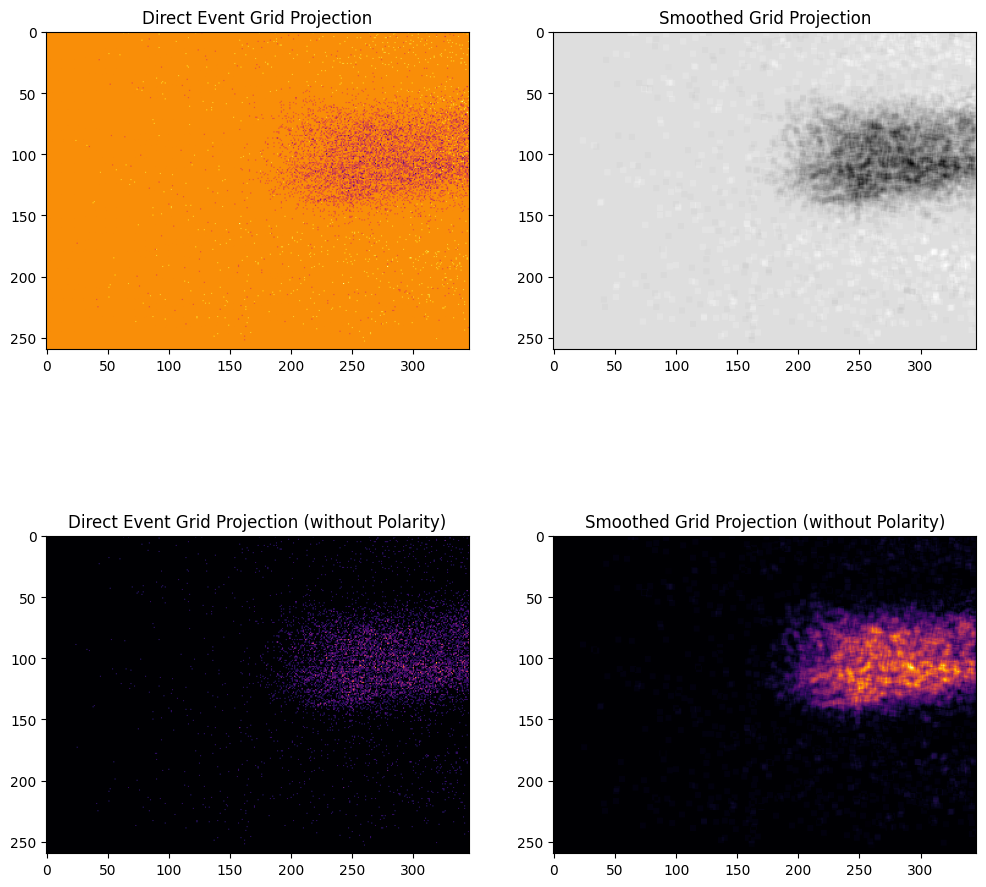

In [91]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'xs', 'ys', 'ts', and 'ps' are defined appropriately
# Define the function to create a 3D grid
def create_3d_event_grid(xs, ys, ts, ps, sensor_size, time_resolution, total_time):
    num_slices = int(total_time / time_resolution)
    grid = torch.zeros((num_slices, sensor_size[0], sensor_size[1]), dtype=torch.float32).cuda()

    # Calculate indices in the time dimension
    time_indices = (ts / time_resolution).long()
    
    print("xs.min(): ", xs.min())
    print("xs.max(): ", xs.max())
    print("ys.min(): ", ys.min())
    print("ys.max(): ", ys.max())
    
    # Filter out-of-bound indices
    valid_mask = (xs >= 0) & (xs < sensor_size[1]) & \
                 (ys >= 0) & (ys < sensor_size[0]) & \
                 (time_indices >= 0) & (time_indices < num_slices)
    print("valid_mask: ", valid_mask)
    print("valid_mask.shape: ", valid_mask.shape)
    print("sum(valid_mask): ", sum(valid_mask))
    
    # Apply mask
    valid_xs = xs[valid_mask]
    valid_ys = ys[valid_mask]
    valid_time_indices = time_indices[valid_mask]
    valid_ps = ps[valid_mask]
    
    # valid_xs = xs
    # valid_ys = ys
    # valid_time_indices = time_indices
    # valid_ps = ps
    
    print("valid_xs.shape: ", valid_xs)
    print("valid_time_indices: ", valid_time_indices)

    # Accumulate weights into the grid
    indices = (valid_time_indices.long(), valid_ys.long(), valid_xs.long())
    
    grid.index_put_(indices, valid_ps.float(), accumulate=True)

    return grid



# Warp the events
xw, yw = warp(xs, ys, ts, ts.min(), torch.tensor(final_velocities[0], device="cuda")/delta_t.item(), torch.tensor(final_velocities[1], device="cuda")/delta_t.item())
    
# Create the 3D grid of events
total_time = 1e5  # total time of events in seconds
time_resolution = 1e2  # time resolution in seconds
sensor_size = (260, 346)  # sensor dimensions
event_grid = create_3d_event_grid(xw, yw, ts, ps, sensor_size, time_resolution, total_time)

# Add a batch and channel dimension
event_grid = event_grid.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, Time, Height, Width]

# Apply 3D convolution
print("event_grid.shape: ", event_grid.shape)

# Define the smoothing filter
kernel_size = 5
padding = kernel_size // 2
weights = torch.ones((1, 1, kernel_size, kernel_size, kernel_size), device="cuda") / (kernel_size ** 3)

# Apply the convolution
smoothed_grid = F.conv3d(event_grid, weights, padding=padding)


print("convolved_grid.shape: ", smoothed_grid.shape)

# # Sum over the time dimension
# image_projection = event_grid.sum(dim=2).squeeze()  # Removing batch and channel dimensions
# # image_projection = smoothed_grid.sum(dim=2).squeeze()  # Removing batch and channel dimensions

# print("image_projection.shape: ", image_projection.shape)

# # Plot the result
# plt.figure(figsize=(10, 5))
# plt.imshow(image_projection.cpu().detach(), cmap='gray')
# plt.colorbar()
# plt.title("Projected Image from Convolved Events")
# plt.show()


# Sum over the time dimension for both grids
direct_summed_image = event_grid.sum(dim=2).squeeze()
smoothed_summed_image = smoothed_grid.sum(dim=2).squeeze()

# Plotting
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
ax1.imshow(direct_summed_image.cpu().numpy(), cmap='inferno')
ax1.set_title("Direct Event Grid Projection")
# ax1.colorbar()

ax2.imshow(smoothed_summed_image.cpu().numpy(), cmap='gray')
ax2.set_title("Smoothed Grid Projection")
# ax2.colorbar()

ax3.imshow(direct_summed_image.cpu().abs().numpy(), cmap='inferno')
ax3.set_title("Direct Event Grid Projection (without Polarity)")
# ax1.colorbar()

ax4.imshow(smoothed_summed_image.cpu().abs().numpy(), cmap='inferno')
ax4.set_title("Smoothed Grid Projection (without Polarity)")
# ax2.colorbar()

plt.show()

image_projection.shape